knN (k-nächste Nachbarn) Klassifizierung zur Vorhersage der RUL.

Model soll die folgende Frage beantworten: In wie vielen Messperioden kommt es zum nächsten Ausfall?

Model nutzt für die Vorhersage die Temperatur und die Leistungsaufnahme

In [1]:
# Daten einlesen

%matplotlib inline
import pymssql
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib

conn = pymssql.connect("pcs.f4.htw-berlin.de",
                       "Masterprojekt", "Masterprojekt", "PraediktiveAnalysenTest")
cursor = conn.cursor()

df = pd.read_sql('SELECT * FROM Maschinendaten_20181206', conn)
conn.close()
"""
# unnötige Spalten entfernen
df.pop('Timestamp')
df.pop('Produktionsprogramm')
df.pop('SollMenge')
df.pop('IstMenge')
df.pop('Ausschuss')
df.pop('Machine_ID')
df.pop('Maschine')
df.pop('Datum')
df.pop('Uhrzeit')
df.pop('ID')"""

# umgekehrt sortieren
df = df.sort_index(ascending=False)


In [2]:
# Kopie anlegen
df_f = df

# Datensätze filtern nach ... und in neuer Variable speichern df_f f=gefiltert
# ... ungeplanten Stillständen (Zufallsfehler)
df_f = df_f.query('FehlerID != "A000"')
df_f = df_f.query('FehlerID != "A001"')
df_f = df_f.query('FehlerID != "A002"')
df_f = df_f.query('FehlerID != "A003"')
df_f = df_f.query('FehlerID != "A004"')
# FehlerID durchsuchen und Zähler anlegen, der angibt wie lang es bis zu nächsten Ausfall dauert
x = []
y = 0
for row in df_f['FehlerID']:
    if row == "x000":
        y += 1
        x.append(y)
    else:
        y = 0
        x.append(y)
# "Ausfallentfernung" an df_s anhängen
df_f['NaechsterAusfall'] = x
        
# Nächste FehlerID durchsuchen, neue Spalte mit Nächster FehlerID (nF001) erzeugen
x = []
y = "NaN"
for row in df_f['FehlerID']:
    if row == "F001":
        y = "F001"
    elif row == "F002":
        y = "F002"
    else:
        y = y
    x.append(y)
# Fehler ID entfernen
df_f.pop('FehlerID')
# "Nächster FehlerID" an df_s anhängen und in zwei Spalten aufsplitten
df_f['nFail'] = x
df_f = df_f.query('nFail != "NaN"')
df_f = pd.get_dummies(df_f[['Drehzahl','Leistungsaufnahme','Vibration','Lautstaerke','Temperatur','NaechsterAusfall','nFail']])

# Nächster Ausfall in 20/50 Schritten
df_f['nA20'] = df_f['NaechsterAusfall'] < 20
df_f['nA50'] = df_f['NaechsterAusfall'] < 50

len(df_f)

19319

In [3]:
# unnötige Zeilen entfernen
df_f = df_f
df_f = df_f.query('Leistungsaufnahme > 15')
df_f = df_f.query('NaechsterAusfall < 40')
df_f = df_f.query('NaechsterAusfall > 1')
df_f = df_f.query('Temperatur > 99')
len(df_f)

4688

In [4]:
# Model anhand 80 % der Daten erstellen
from sklearn.model_selection import train_test_split
X = df_f[["Temperatur", "Leistungsaufnahme"]].values
y = df_f['nA20'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [5]:
# Modeldaten skalieren, um sie für die knN Klassifizierung nutzbar zu machen
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
X_test[len(X_test)-1]

array([1.83580189, 0.30735657])

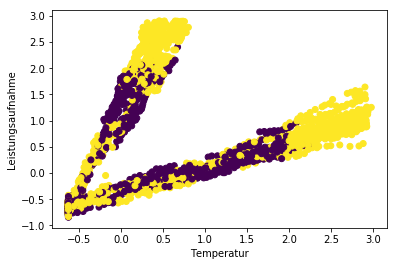

In [7]:
# Modeldaten plotten
plt.scatter(X_train[:,0], X_train[:,1],c = y_train)
plt.xlabel("Temperatur")
plt.ylabel("Leistungsaufnahme")
plt.show()

In [8]:
# knN Model erstellen
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors = 1)
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

In [9]:
# Modeldaten speichern
#from sklearn.externals import joblib
#joblib.dump(model, 'finalized_model.sav')

In [10]:
# Anteil der korrekten Vorhersagen berechnen
model.score(X_test, y_test)

0.582089552238806

In [11]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_predicted)

array([[231, 216],
       [176, 315]], dtype=int64)

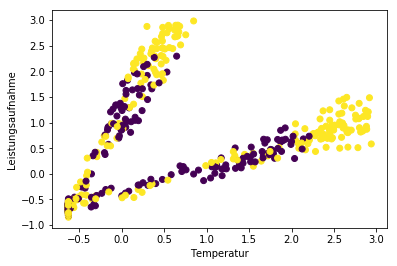

In [12]:
# Test-Modeldaten plotten, Farbwerte = echte nAK Werte
plt.scatter(X_test[:,0], X_test[:,1], c= y_test)
plt.xlabel("Temperatur")
plt.ylabel("Leistungsaufnahme")
plt.show()

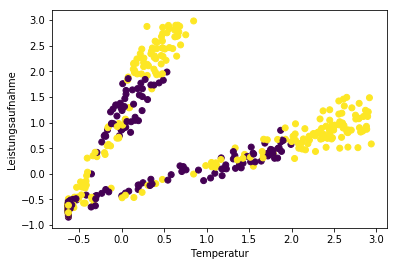

In [13]:
# Test-Modeldaten plotten, Farbwerte = vorhergesagte nAK Werte
plt.scatter(X_test[:,0], X_test[:,1],c = y_predicted)
plt.xlabel("Temperatur")
plt.ylabel("Leistungsaufnahme")
plt.show()

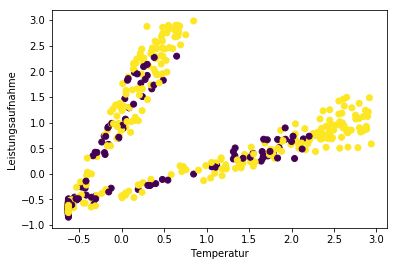

In [14]:
# Test-Modeldaten plotten, Farbwerte = korrekte Vorhersage
plt.scatter(X_test[:,0], X_test[:,1],c = y_predicted == y_test)
plt.xlabel("Temperatur")
plt.ylabel("Leistungsaufnahme")
plt.show()